In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/toxicgen/LSTMGenerator.pt
/kaggle/working/__notebook__.ipynb


In [2]:
# load and process data
# generate dataloader
# define generator (LSTM) and discriminator (LSTM) architecture
# train generator and discriminator with MLE (regular training)
# train generator and discriminator as GAN (adversarial training)

## Libraries

In [3]:
!pip install -q transformers datasets

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam

from datasets import Dataset, DatasetDict, load_from_disk, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

### Constant

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== #
# tokenizers #
# ========== #
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# =============== #
# Hyperparameters #
# =============== #
learning_rate = 1e-4
weight_decay = 0.001
batch_size = 256
hidden_dim = 512
embedding_dim = 256
vocab_size = tokenizer.vocab_size
early_stop_tolerance = 5
log_every = 10
# ---------------------------- #
# Pretraining generator params #
# ---------------------------- #
max_seq_len = 65    # we use 65 because mean and 75% data distribution has length ~60-80
pretrain_gen_epochs = 30
pretrain_gen_lr = 1e-5
pretrain_gen_criterion = nn.NLLLoss()
pretrain_gen_continue_train = True
# -------------------------------- #
# Pretraining discriminator params #
# -------------------------------- #
output_size = 1
n_layers = 2
dropout = 0.3
pretrain_dis_epochs = 15
pretrain_dis_lr = 1e-5
bidirectional = False
pretrain_dis_criterion = nn.BCEWithLogitsLoss()
pretrain_dis_continue_train = False
# ========= #
# BASE PATH #
# ========= #
env = 'kaggle' # change based on notebook environment [kaggle, colab, local]
model_in = {'kaggle': '/kaggle/input/toxicgen/LSTMGenerator.pt',
            'colab': '/drive/MyDrive/ITMO Master/detox/models/gan/LSTMGenerator.pt',
            'local': '../models/gan/LSTMGenerator.pt'}
model_out = {'kaggle': '/kaggle/working',
             'colab': '/content/drive/MyDrive/ITMO Master/detox/models/gan',
             'local': '../models/gan'}
base_tensorboard_path = {'kaggle': '/kaggle/working/runs',
                         'colab': '/content/drive/MyDrive/ITMO Master/detox/reports/runs',
                         'local': '../reports/runs'}
raw_data_path = '../data/raw/jigsaw/jigsaw-multiling-1st-subset/'
interim_data_path = '../data/interim/toxic-cleaned-tokenized'   # cleaned & stored in HF format

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Dataloader

In [7]:
# ======================== #
# Load tokenized from disk #
# ======================== #
tokenized_dataset = load_dataset("affahrizain/jigsaw-toxic-comment")
tokenized_dataset

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/affahrizain--jigsaw-toxic-comment-47d9c78eb9217597/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 47495
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 376855
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 47286
    })
})

In [8]:
tokenized_dataset.set_format('torch')

In [9]:
# As a P.O.C lets train with some sample of datasets
np.random.seed(42)

tokenized_dataset['train_sample'] = tokenized_dataset['train'].select(
        np.random.randint(0, len(tokenized_dataset['train']), 300000))  # using 300K trainset
# tokenized_dataset['validation_sample'] = tokenized_dataset['validation'].select(
#         np.random.randint(0, len(tokenized_dataset['validation']), 50000))  # using 50K trainset
# tokenized_dataset['test_sample'] = tokenized_dataset['test'].select(
#         np.random.randint(0, len(tokenized_dataset['test']), 50000))  # using 50K trainset
tokenized_dataset

DatasetDict({
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 47495
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 376855
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 47286
    })
    train_sample: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 300000
    })
})

In [10]:
trainloader = DataLoader(tokenized_dataset['train_sample'], shuffle=True, batch_size=batch_size)
validloader = DataLoader(tokenized_dataset['validation'], shuffle=True, batch_size=batch_size)
testloader = DataLoader(tokenized_dataset['test'], shuffle=True, batch_size=batch_size)

## Network Architecture

In [11]:
class LSTMGenerator(nn.Module):
    '''
    Seq2seq model that intended to generate next word sequences.
    The architecture was inspired from https://github.com/rtst777/TextGAN.git
    '''
    def __init__(self, vocab_size, embed_size, hidden_size, max_seq_len, padding_idx, device=device):
        super(LSTMGenerator, self).__init__()

        # ---------------- #
        # model properties #
        # ---------------- #
        self.name = 'LSTMGenerator'
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.max_seq_len = max_seq_len
        self.padding_idx = padding_idx
        self.temperature = 1.0
        self.device = device
        if isinstance(device, str):
            self.device = torch.device(device)

        # ------------ #
        # model layers #
        # ------------ #
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.lstm2out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=-1)

        # put to device by default
        self.to(device)

    def forward(self, x, hidden, need_hidden=False):
        '''
        Embeds input and applies LSTM
        :param x: batch_size * seq_len
        :param hidden: (h, c)
        :param need_hidden: if True return hidden, use for sampling
        '''
        emb = self.embedding(x)     # batch_size * len * embedding_dim
        if len(x.size()) == 1:
            emb = emb.unsqueeze(1)   # batch_size * 1 * embedding_dim

        # print('Input shape: ', x.shape)
        # print('Embedding shape: ', emb.shape)

        out, hidden = self.lstm(emb, hidden)    # out: batch_size * seq_len * hidden_dim
        # print('LSTM shape: ', out.shape)
        # out = out.contiguous().view(-1, self.hidden_size)   # out: batch_size * seq_len        
        # print('LSTM reshape shape: ', out.shape)
        out = self.dropout(self.lstm2out(out))    # batch_size * seq_len * vocab_size
        # print('Logits shape: ', out.shape)
        out = self.temperature * out
        pred = self.softmax(out)
        # print('Softmax shape: ', pred.shape)

        if need_hidden:
            return pred, hidden
        else:
            return pred

    def sample(self, num_samples, batch_size, start_letter=0, seq_len=None):
        '''
        Samples the network (generate words) and returns num_samples samples of length max_seq_len based on multinomial distribution.
        :return samples: num_samples * max_seq_length (a sampled sequence in a row)
        '''
        # estimate batch required to generate num_samples samples
        num_batch = num_samples // batch_size if num_samples > batch_size else 1
        # prepare output for each row
        samples = torch.zeros(num_batch * batch_size, seq_len, device=self.device).long()
        samples[:, 0] = start_letter
        
        if seq_len is None:
            seq_len = self.max_seq_len

        # start sampling (generates)
        for b in range(num_batch):
            # init hidden and cell state
            hidden = self.init_hidden(batch_size)
            # init first token input for every row in batch_size
            if device.type == 'cpu':
                x = torch.LongTensor([start_letter] * batch_size, device=self.device)
            else:
                x = torch.cuda.LongTensor([start_letter] * batch_size, device=self.device)


            # generate sentence with maximum length = max_seq_len
            for i in range(1, seq_len):
                # forward pass to get logits
                out, hidden = self.forward(x, hidden, need_hidden=True)     # get hidden for next forward pass
                out = out.contiguous().view(-1).div(self.temperature)
                # sampling multinomial for predicted next token
                next_token = torch.multinomial(torch.exp(out), 1).view(-1)  # flatten to batch_size
                # put predicted next_token in samples
                samples[b : (b + 1) * batch_size, i] = next_token
                # replace initial input with generated next_token
                x = next_token
        
        # select only num_samples of samples
        if num_samples == 1:
            return samples.squeeze()
        return samples[:num_samples]

    def sample_vanilla(self, num_samples, batch_size, start_letter=0, seq_len=None):
        '''
        Samples the network (generate words) and returns num_samples of length max_seq_len based on argmax.
        :return samples: num_samples * max_seq_length (a sampled sequence in a row)
        '''

        # estimate batch required to generate num_samples samples
        num_batch = num_samples // batch_size if num_samples > batch_size else 1
        # prepare output for each row
        samples = torch.zeros(num_batch * batch_size, self.max_seq_len, device=self.device).long()
        samples[:, 0] = start_letter
        
        if seq_len is None:
            seq_len = self.max_seq_len

        # start sampling (generates)
        for b in range(num_batch):
            # init hidden and cell state
            hidden = self.init_hidden(batch_size)
            # init first token input for every row in batch_size
            if device.type == 'cpu':
                x = torch.LongTensor([start_letter] * batch_size, device=self.device)
            else:
                x = torch.cuda.LongTensor([start_letter] * batch_size, device=self.device)


            # generate sentence with maximum length = max_seq_len
            for i in range(1, seq_len):
                # forward pass to get logits
                out, hidden = self.forward(x, hidden, need_hidden=True)     # get hidden for next forward pass
                # using argmax for predicted next token                
                next_token = torch.argmax(out, dim=1).view(-1)  # flatten to batch_size
                # put predicted next_token in samples
                samples[b : (b + 1) * batch_size, (i + 1)] = next_token
                # replace initial input with generated next_token
                x = next_token
        
        # select only num_samples of samples
        if num_samples == 1:
            return samples.squeeze()
        return samples[:num_samples]

    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, self.hidden_size, device=self.device)
        c = torch.zeros(1, batch_size, self.hidden_size, device=self.device)

        return h, c

    @staticmethod
    def add_gumbel(self, theta, eps=1e-10):
        '''
        Adding Gumbel-trick to our current theta to enable adversarial training for discrete data.
        :return theta + g_t: relaxed softmax with gumbel distribution.
        '''
        u = torch.zeros(theta.size(), device=device)
        u.uniform_(0, 1)
        # generate gumbel distribution
        g_t = -torch.log(-torch.log(u + eps) + eps)
        
        return theta + g_t

In [12]:
class LSTMDiscriminator(nn.Module):
    '''
    Binary classification model that intended to predict either data is real or fake.
    The architecture was simple and inspired from https://github.com/fhrzn/all-about-rnn/tree/master/sentiment-analysis
    '''
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, padding_idx, 
                    n_layers=2, dropout=.3, device=device, bidirectional=False):
        super(LSTMDiscriminator, self).__init__()

        # ---------------- #
        # model properties #
        # ---------------- #
        self.name = 'LSTMDiscriminator'
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.padding_idx = padding_idx
        self.n_layers = n_layers
        self.dropout = dropout
        self.device = device
        self.bidirectional = 2 if bidirectional else 1
        if isinstance(device, str):
            self.device = torch.device(device)

        # ------------ #
        # model layers #
        # ------------ #
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)    

        # put to device by default
        self.to(device)

    def forward(self, x, hidden):
        '''
        Embeds input and applies LSTM
        :param x: batch_size * seq_len
        :param hidden: (h, c)
        '''
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        out = out[:, -1, :]     # get last sequence output
        out = self.fc(self.dropout(out))

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers * self.bidirectional * 1, batch_size, self.hidden_size, device=self.device)
        c = torch.zeros(self.n_layers * self.bidirectional * 1, batch_size, self.hidden_size, device=self.device)

        return h, c

    @staticmethod
    def get_feature(self):
        # TODO: "Not implemented yet"
        pass

## Pretraining

### Generator (Seq2seq Training)

In [13]:
gen = LSTMGenerator(vocab_size=vocab_size,
                    embed_size=embedding_dim,
                    hidden_size=hidden_dim,
                    max_seq_len=max_seq_len,
                    padding_idx=tokenizer.pad_token_id,
                    device=device)

In [14]:
# if there is pretrained model, then continue training
if pretrain_gen_continue_train and os.path.exists(model_in[env]):
    weights = torch.load(model_in[env], map_location=device)
    gen.load_state_dict(weights)
    print('Weights loaded.')

Weights loaded.


In [15]:
gen_optim = Adam(gen.parameters(), lr=pretrain_gen_lr, weight_decay=weight_decay)
gen_writer_pretrain = SummaryWriter(f'{base_tensorboard_path[env]}/pretrain/gen')

history = {
    'train_loss': [],
    'validation_loss': [],
    'test_loss': [],
    'epochs': 0
}

In [16]:
# ============= #
# Training Loop #
# ============= #

# early stop trigger
gen_es_trigger = 0
gen_val_loss_min = torch.inf

epochloop = tqdm(range(pretrain_gen_epochs), position=0, desc='Training...', leave=True)

for e in epochloop:

    # ------------- #
    # training mode #
    # ------------- #
    gen.train()
    gen_train_loss = 0

    for feature in tqdm(trainloader, desc='Batch Train'):
        # gen_feature = feature['input_ids'][:, :-1].long()
        # gen_target = feature['input_ids'][:, 1:]
        gen_feature = feature['input_ids'].long()

        # move to device
        gen_feature = gen_feature.to(device)
        # gen_target = gen_target.to(device)
        
        # init hidden_state
        # gen_hidden = gen.init_hidden(batch_size)

        # forward pass
        gen_out = gen(gen_feature, None)
        gen_out = gen_out[:, :-1]
        gen_target = gen_feature[:, 1:]

        # compute loss
        gen_loss = pretrain_gen_criterion(gen_out.contiguous().view(-1, vocab_size), 
                                          gen_target.contiguous().view(-1))

        gen_loss.backward()
        gen_optim.step()

        gen_train_loss += gen_loss.item()


    # write report to tensorboard
    gen_writer_pretrain.add_scalar('Training Loss', gen_train_loss / len(trainloader), global_step=e)
    history['train_loss'].append(gen_train_loss / len(trainloader))


    # --------------- #
    # validation mode #
    # --------------- #

    gen.eval()
    gen_val_loss = 0

    with torch.no_grad():
        # init hidden_state
        gen_hidden = gen.init_hidden(batch_size)
        for feature in tqdm(validloader, desc='Batch Validation'):
            # gen_feature = feature['input_ids'][:, :-1].long()
            # gen_target = feature['input_ids'][:, 1:]
            gen_feature = feature['input_ids'].long()

            # move to device
            gen_feature = gen_feature.to(device)
            # gen_target = gen_target.to(device)
            
            

            # forward pass
            gen_out = gen(gen_feature, None)
            gen_out = gen_out[:, :-1]
            gen_target = gen_feature[:, 1:]

            # compute loss
            gen_loss = pretrain_gen_criterion(gen_out.contiguous().view(-1, vocab_size), 
                                            gen_target.contiguous().view(-1))

            # write loss
            gen_val_loss += gen_loss.item()

        
    # write report to tensorboard
    gen_writer_pretrain.add_scalar('Validation Loss', gen_val_loss / len(validloader), global_step=e)
    history['validation_loss'].append(gen_val_loss / len(validloader))

    # write generator sample to tensorboard
    # gen_samples = [tokenizer.decode(i) for i in gen.sample(3, 1, start_letter=tokenizer.cls_token_id)]
    gen_writer_pretrain.add_text(f'{gen.name}-step-{e}', tokenizer.decode(gen.sample(1, 1, start_letter=2017, seq_len=10)))

    # print log for every epoch
    epochloop.set_postfix_str(f'Val Loss: {gen_val_loss / len(validloader):.3f}')
    epochloop.write(f'E: {e+1}/{pretrain_gen_epochs} | Train Loss: {gen_train_loss / len(trainloader):.4f} | Val Loss: {gen_val_loss / len(validloader):.4f}')
    

    # for each epoch save model if validation loss decrease
    if gen_val_loss / len(validloader) <= gen_val_loss_min:
        torch.save(gen.state_dict(), f'{model_out[env]}/{gen.name}.pt')    # TODO: add running datetime log to the name
        gen_val_loss_min = gen_val_loss / len(validloader)
        gen_es_trigger = 0
    else:        
        epochloop.write(f'[WARN] Loss didn\'t improving ({gen_val_loss_min:.3f}) --> {gen_val_loss / len(validloader):.4f}')
        gen_es_trigger += 1

    # force early stop
    if gen_es_trigger >= early_stop_tolerance:
        epochloop.write(f'Early stopped at Epoch-{e}')
        history['epochs'] = e
        break
        
    history['epochs'] += 1
    epochloop.update()

Training...:   0%|          | 0/30 [00:00<?, ?it/s]

Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 1/30 | Train Loss: 5.6192 | Val Loss: 4.0465


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 2/30 | Train Loss: 5.5934 | Val Loss: 4.0158


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 3/30 | Train Loss: 5.5749 | Val Loss: 4.0337
[WARN] Loss didn't improving (4.016) --> 4.0337


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 4/30 | Train Loss: 5.5486 | Val Loss: 4.0167
[WARN] Loss didn't improving (4.016) --> 4.0167


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 5/30 | Train Loss: 5.5219 | Val Loss: 3.9898


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 6/30 | Train Loss: 5.4991 | Val Loss: 4.0239
[WARN] Loss didn't improving (3.990) --> 4.0239


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 7/30 | Train Loss: 5.4778 | Val Loss: 3.9963
[WARN] Loss didn't improving (3.990) --> 3.9963


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 8/30 | Train Loss: 5.4613 | Val Loss: 3.9548


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 9/30 | Train Loss: 5.4440 | Val Loss: 3.9852
[WARN] Loss didn't improving (3.955) --> 3.9852


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 10/30 | Train Loss: 5.4263 | Val Loss: 3.9462


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 11/30 | Train Loss: 5.4078 | Val Loss: 3.9140


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 12/30 | Train Loss: 5.3910 | Val Loss: 3.9567
[WARN] Loss didn't improving (3.914) --> 3.9567


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 13/30 | Train Loss: 5.3741 | Val Loss: 3.8874


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 14/30 | Train Loss: 5.3572 | Val Loss: 3.9294
[WARN] Loss didn't improving (3.887) --> 3.9294


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 15/30 | Train Loss: 5.3410 | Val Loss: 3.8747


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 16/30 | Train Loss: 5.3279 | Val Loss: 3.8889
[WARN] Loss didn't improving (3.875) --> 3.8889


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 17/30 | Train Loss: 5.3144 | Val Loss: 3.8910
[WARN] Loss didn't improving (3.875) --> 3.8910


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 18/30 | Train Loss: 5.3016 | Val Loss: 3.8749
[WARN] Loss didn't improving (3.875) --> 3.8749


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 19/30 | Train Loss: 5.2896 | Val Loss: 3.8911
[WARN] Loss didn't improving (3.875) --> 3.8911


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 20/30 | Train Loss: 5.2782 | Val Loss: 3.8368


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 21/30 | Train Loss: 5.2672 | Val Loss: 3.8260


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 22/30 | Train Loss: 5.2564 | Val Loss: 3.8408
[WARN] Loss didn't improving (3.826) --> 3.8408


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 23/30 | Train Loss: 5.2470 | Val Loss: 3.8421
[WARN] Loss didn't improving (3.826) --> 3.8421


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 24/30 | Train Loss: 5.2384 | Val Loss: 3.8321
[WARN] Loss didn't improving (3.826) --> 3.8321


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 25/30 | Train Loss: 5.2282 | Val Loss: 3.8443
[WARN] Loss didn't improving (3.826) --> 3.8443


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 26/30 | Train Loss: 5.2209 | Val Loss: 3.8198


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 27/30 | Train Loss: 5.2106 | Val Loss: 3.8451
[WARN] Loss didn't improving (3.820) --> 3.8451


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 28/30 | Train Loss: 5.2027 | Val Loss: 3.8124


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 29/30 | Train Loss: 5.1943 | Val Loss: 3.8126
[WARN] Loss didn't improving (3.812) --> 3.8126


Batch Train:   0%|          | 0/1172 [00:00<?, ?it/s]

Batch Validation:   0%|          | 0/186 [00:00<?, ?it/s]

E: 30/30 | Train Loss: 5.1862 | Val Loss: 3.8281
[WARN] Loss didn't improving (3.812) --> 3.8281


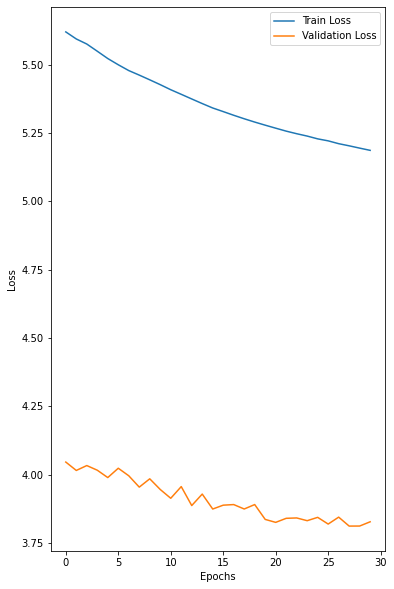

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 10))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['validation_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# try to generate samples after training
tokenizer.decode(gen.sample(1, 1, 2017, 10))

'you fuck nigga ni lawn trusting kinase anthology!'

In [ ]:
samples = gen.sample(3, 1, start_letter=tokenizer.convert_tokens_to_ids('you'), seq_len=15)

In [ ]:
for s in samples:
    print(tokenizer.decode(s))
    print('-----------------')

you fucked emergency 郡 strikes, and subsequently demonstrated there to provide an afl and
-----------------
you blocked alps recitaldge shown in finale metacritic antiquityら fuels into quarters and
-----------------
you fuck hilbert niggas! i hate you delivered a fucking pussy ugly
-----------------
